<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)

In [3]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x)
  return pd.DataFrame(X)

data2 = split_sequence(data1, 10)
print(data2.shape)
print(data2)

(771, 10)
           0        1        2         3         4         5         6  \
0    2515.25  2596.98  2725.08   2643.35   2679.99   2690.76   2574.84   
1    2596.98  2725.08  2643.35   2679.99   2690.76   2574.84   2505.61   
2    2725.08  2643.35  2679.99   2690.76   2574.84   2505.61   2407.91   
3    2643.35  2679.99  2690.76   2574.84   2505.61   2407.91   2575.75   
4    2679.99  2690.76  2574.84   2505.61   2407.91   2575.75   2553.12   
..       ...      ...      ...       ...       ...       ...       ...   
766  9751.24  9880.67  9841.96   9468.92   9549.70   9503.32   9580.00   
767  9880.67  9841.96  9468.92   9549.70   9503.32   9580.00  10099.00   
768  9841.96  9468.92  9549.70   9503.32   9580.00  10099.00  10417.24   
769  9468.92  9549.70  9503.32   9580.00  10099.00  10417.24  10533.07   
770  9549.70  9503.32  9580.00  10099.00  10417.24  10533.07  10820.75   

            7         8         9  
0     2505.61   2407.91   2575.75  
1     2407.91   2575.75   255

In [4]:
train_x = data2.iloc[:int(0.85*len(data2)), :9]
train_y = data2.iloc[:int(0.85*len(data2)), 9:10]
test_x = data2.iloc[int(0.85*len(data2)):, :9]
test_y = data2.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(655, 9)
(655, 1)
(116, 9)
(116, 1)


In [5]:
qqqq = 2*np.random.random((3, 1)) - 1
print(np.sin(qqqq))

[[-0.51498447]
 [-0.22718357]
 [ 0.28774048]]


In [6]:
s = np.sin(qqqq)
c = np.cos(qqqq)
print(s)
print(c)
print(qqqq + s + c)

[[-0.51498447]
 [-0.22718357]
 [ 0.28774048]]
[[0.85719951]
 [0.97385195]
 [0.95770842]]
[[-0.19877451]
 [ 0.51748373]
 [ 1.5373156 ]]


In [7]:
class TFLANN():
  def __init__(self):
    self.weight_matrix = 2*np.random.random((9*3, 1)) - 1
  
  def func_x(self, x):
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x))
    return functioned_x

  def tanh_derivative(self, x):
    return 1.0 - (np.tanh(x) ** 2)

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return np.dot(funced_x, self.weight_matrix)

  def train(self, train_x, train_y, epochs):
    for iteration in range(epochs):
      y = self.forward_propagation(train_x)

      error = y - train_y

      adjustment = np.dot(self.func_x(train_x).T, error * self.tanh_derivative(y))

      self.weight_matrix += adjustment
      for w in self.weight_matrix:
        print(str(round(w[0], 2)) + " ", end="")
      print("epoch ")

In [11]:
model = TFLANN()
model.train(train_x = train_x, train_y = train_y, epochs = 1000)
preds = model.forward_propagation(test_x)
print(preds.shape)

0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 0.54 -0.15 0.16 -0.81 -0.5 0.46 0.54 0.85 0.01 -0.7 0.62 epoch 
0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 0.54 -0.15 0.16 -0.81 -0.5 0.46 0.54 0.85 0.01 -0.7 0.62 epoch 
0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 0.54 -0.15 0.16 -0.81 -0.5 0.46 0.54 0.85 0.01 -0.7 0.62 epoch 
0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 0.54 -0.15 0.16 -0.81 -0.5 0.46 0.54 0.85 0.01 -0.7 0.62 epoch 
0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 0.54 -0.15 0.16 -0.81 -0.5 0.46 0.54 0.85 0.01 -0.7 0.62 epoch 
0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 0.54 -0.15 0.16 -0.81 -0.5 0.46 0.54 0.85 0.01 -0.7 0.62 epoch 
0.35 -0.32 0.79 0.37 0.35 -0.97 0.17 0.24 -0.39 -0.52 -0.13 -0.02 -1.0 0.64 -0.41 -0.98 

In [12]:
preds[:, 0]

array([3042.76655992, 3043.81113014, 3317.19462626, 3247.51331462,
       3255.7916156 , 2884.67388701, 3222.07327379, 2936.38406522,
       3017.60119642, 2911.79851777, 3112.62954533, 2989.32183242,
       3207.07137059, 3238.47757056, 3061.75177926, 3160.44849499,
       3582.42136983, 3498.49643602, 3239.6936669 , 3114.16330194,
       3211.20017474, 2899.39395807, 2918.4866347 , 3010.98212002,
       2905.15854076, 2876.07657753, 3084.20035736, 3318.96481484,
       3269.18162523, 2844.26693255, 3106.99041891, 2868.60511109,
       2394.93565482, 3230.90901551, 3010.1612736 , 3924.2010659 ,
       3542.85967909, 4575.66049814, 5110.96181018, 5444.34594017,
       4122.9792033 , 4192.28996663, 4444.32033854, 5312.01300863,
       4209.45151393, 4589.50595943, 4503.34231808, 4177.57208866,
       4448.77445917, 4713.14387388, 5280.19906889, 5410.62639264,
       5479.80362227, 5429.881643  , 4786.3661273 , 5838.51520217,
       5706.9754908 , 5555.27806103, 4929.14755594, 4582.75440

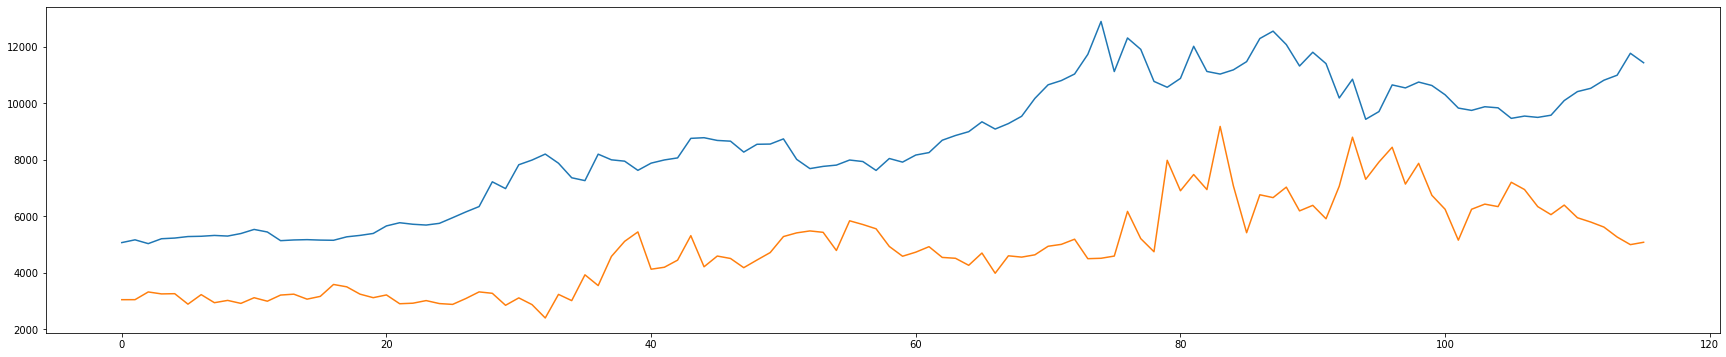

In [13]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.show()
     